In [25]:
import numpy as np
import cv2
from skimage import io
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt

from pathlib import Path
import json
import matplotlib.patches as patches
from time import time

NOMINAL = 160 #50 + 10 # color 200+20
RANGE = 20

3


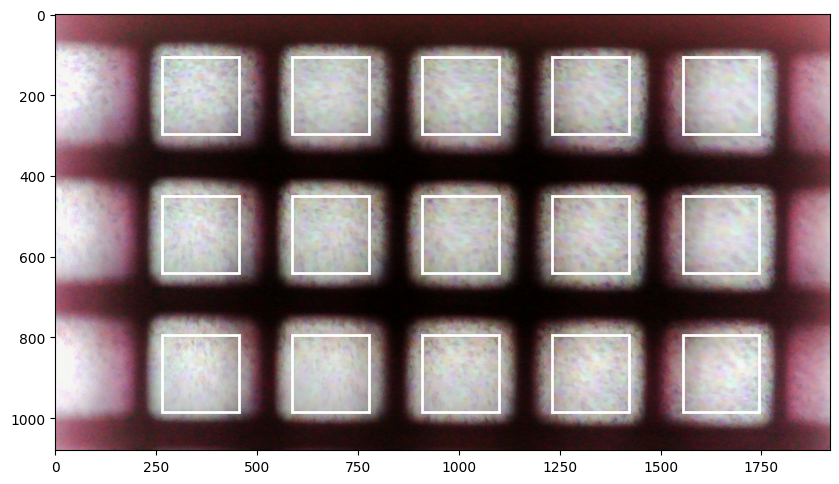

In [26]:
import json

# 读取JSON文件并解析变量
# with open("./config/sensor_r.json", "r") as f:
with open("/home/lifan/Documents/GitHub/Flip-Journal/config/sensor_02.json","r") as f:
    data = json.load(f)
    ncol = data["ncol"]
    nrow = data["nrow"]
    x_0 = data["x_0"]
    y_0 = data["y_0"]
    x_end = data["x_end"]
    y_end = data["y_end"]
    w = data["w"]
    h = data["h"]

rect = []
for i in range(ncol):
    row = []
    for j in range(nrow):
        center_x = int(x_0 + j * (x_end - x_0) / (nrow - 1) if nrow > 1 else x_0 + (x_end - x_0) / 2)
        center_y = int(y_0 + i * (y_end - y_0) / (ncol - 1) if ncol > 1 else y_0 + (y_end - y_0) / 2)
        x1 = int(center_x - w / 2)
        y1 = int(center_y - h / 2)
        x2 = int(center_x + w / 2)
        y2 = int(center_y + h / 2)
        row.append(((x1, y1), (x2, y2), (center_x, center_y)))
    rect.append(row)

print(np.array(rect).shape[0])
    
fig,ax = plt.subplots(figsize=(10,10))

# # image = cv2.imread("./pics/pic0.jpg")
# image = cv2.imread("blob_detection.jpg")
# image = cv2.imread("color.png")
# image = cv2.imread("./Tactile_pics/pic1.jpg")
image = np.load("/home/lifan/Documents/GitHub/Flip-Journal/book_touch_video1/index_frame_49.npy")

# Display the image
ax.imshow(image, cmap='gray')
ax.axis('on')

k = 1
left_top1 = [0,0]
right_bottom1 = [0,0]


for i in range(ncol):
    for j in range(nrow):
        (x1, y1), (x2, y2), _ = rect[i][j]  # 获取当前矩形的左下角、右上角坐标

        left_top = (x1, y1)
        right_bottom = (x2, y2)
        
        # Create a Rectangle patch
        rect_patch = patches.Rectangle((left_top[0],left_top[1]),
                                right_bottom[0]-left_top[0],right_bottom[1] - left_top[1],
                                linewidth=2, edgecolor='w',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect_patch)

        # cut roi tiles and save
        img_tile = image[int(left_top[1]):int(right_bottom[1]), int(left_top[0]):int(right_bottom[0]), :]
        # plt.figure()
        # plt.title(k)
        # plt.imshow(img_tile)
    #     plt.imshow(cv2.flip(img_tile, -1))
        k = k + 1





/tmp/ipykernel_459219/1741047941.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hstack == []:
/tmp/ipykernel_459219/1741047941.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if vstack == []:


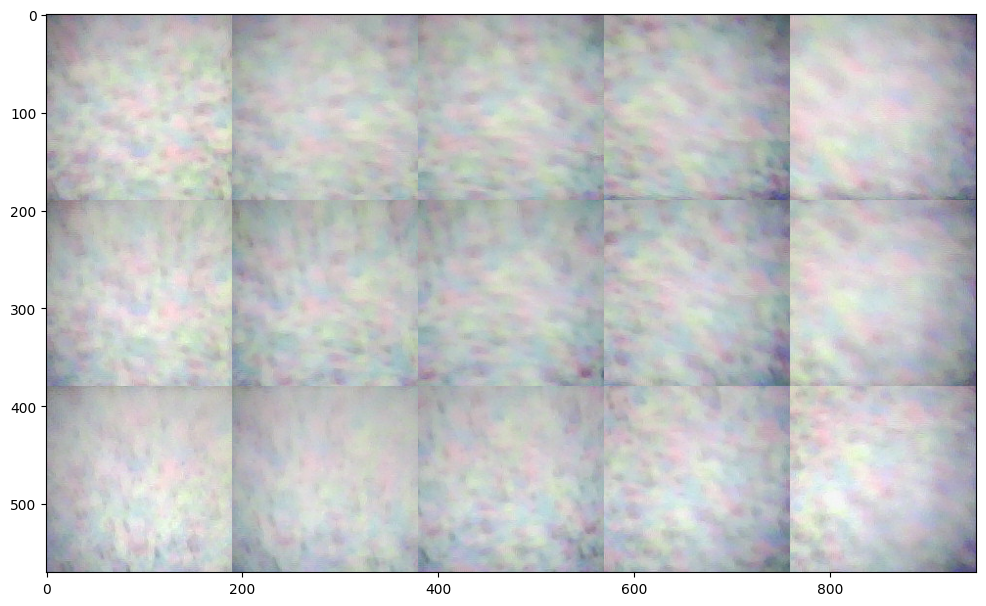

In [27]:
ncol = 5
nrow = 3

vstack = []
tile_list = []
for i in range(nrow):
    hstack = []
    for j in range(ncol):
        (x1, y1), (x2, y2), _ = rect[i][j]  # 获取当前矩形的左上角、右下角坐标

        left_top = (x1, y1)
        right_bottom = (x2, y2)

        tile = image[int(left_top[1]):int(right_bottom[1]),
                    int(left_top[0]):int(right_bottom[0]), :]
        tile_flipped = cv2.flip(tile, -1)
        
        tile_list.append(tile_flipped)
        if hstack == []:
            hstack = tile_flipped
        else:
            hstack = np.hstack((hstack, tile_flipped))
    if vstack == []:
        vstack = hstack
    else:
        vstack = np.vstack((vstack, hstack))

plt.figure(figsize=(12,12))
# plt.imshow(vstack, cmap='gray')
plt.imshow(cv2.cvtColor(vstack, cv2.COLOR_RGB2BGR))


# plt.figure(figsize=(12,12))
# plt.imshow(vstack, cmap='gray')


(190, 190, 3) (190, 190, 3)


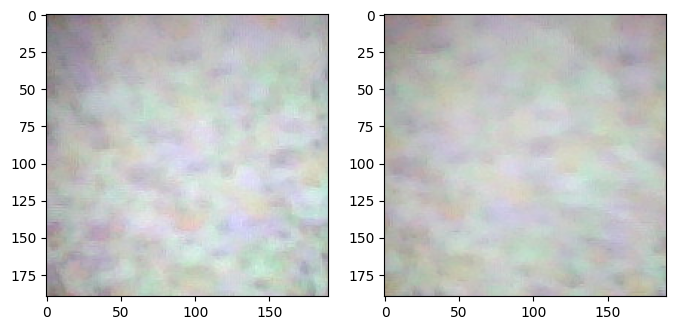

In [28]:
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
img1 = tile_list[0]
img2 = tile_list[1]

fig, ax = plt.subplots(1,2, figsize=(8, 5))
ax = ax.ravel()

ax[0].imshow(img1[:,:, :].astype(np.uint8), cmap='gray')
ax[1].imshow(img2[:,:, :].astype(np.uint8), cmap='gray')
print(img1.shape, img2.shape)

In [29]:
print(cv2.__version__)

4.7.0


In [30]:
# ol_w = [6,8,7,9,5,7,6] ground truth
# assume that the overlapping is around 10% of roi size
dim = 1
nominal_ov_pos = NOMINAL
bound = RANGE # +- bounds around nominal_ov_pos

ov_position = [i for i in range(nominal_ov_pos - bound, nominal_ov_pos+bound+1)] #find overlapping position from 40 to 81
# print(ov_position)

def find_ov(img1, img2, nominal_ov, bound_ov, dim=1):
    '''
        default dimension is along axis 1 (width of the images)
    '''
    cross_corr = []
    tested_ov = range(nominal_ov - bound_ov, nominal_ov+bound_ov + 1)
    for ov in tested_ov:
        if dim == 1:
            ov_area1 = img1[:, -ov:,:]
            ov_area2 = img2[:,  :ov,:]
        elif dim == 0:
            ov_area1 = img1[-ov:, :,:]
            ov_area2 = img2[:ov,  :,:]
        corr = 0.0
        for i in range(3):
            a = ov_area1[:,:,i]/1.0
            b = ov_area2[:,:, i]/1.0
            corr = corr + np.sum(np.multiply(a, b)) / np.sqrt(np.sum(a**2) * np.sum(b**2))
        corr = corr/3.0

        cross_corr.append(corr)
    ov_pos = tested_ov[np.argmax(cross_corr)]
    print(max(cross_corr))
    if dim == 1:
        ov_1 = img1[:, -ov_pos:, :]
        ov_2 = img2[:,  :ov_pos, :]
    elif dim == 0:
        ov_1 = img1[-ov_pos:, :, :]
        ov_2 = img2[:ov_pos,  :, :]
    
    return ov_pos, ov_1, ov_2, cross_corr

img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)
t1 = time()
ov_pos, ov1, ov2, cross_corr = find_ov(img1, img2, nominal_ov_pos, bound, dim=dim)
print(ov_pos)
print(time()- t1)
print(cross_corr)

0.9980224370956421
168
0.040946245193481445
[0.9974061846733093, 0.997452954451243, 0.9975034991900126, 0.9975398381551107, 0.9975747068723043, 0.9976026018460592, 0.9976367950439453, 0.9976622859636942, 0.9976921280225118, 0.9977153142293295, 0.9977472225824991, 0.9977704683939616, 0.9977994958559672, 0.9978212118148804, 0.9978520274162292, 0.9978747765223185, 0.9979023337364197, 0.9979193011919657, 0.9979422291119894, 0.9979560176531473, 0.9979743957519531, 0.9979828198750814, 0.9979975422223409, 0.99799911181132, 0.9980087876319885, 0.9980106552441915, 0.998018483320872, 0.9980179667472839, 0.9980224370956421, 0.9980199933052063, 0.9980217417081197, 0.9980149666468302, 0.998012363910675, 0.998003621896108, 0.9980017145474752, 0.9979922970136007, 0.9979885021845499, 0.9979764223098755, 0.997966488202413, 0.997947096824646, 0.9979320963223776]


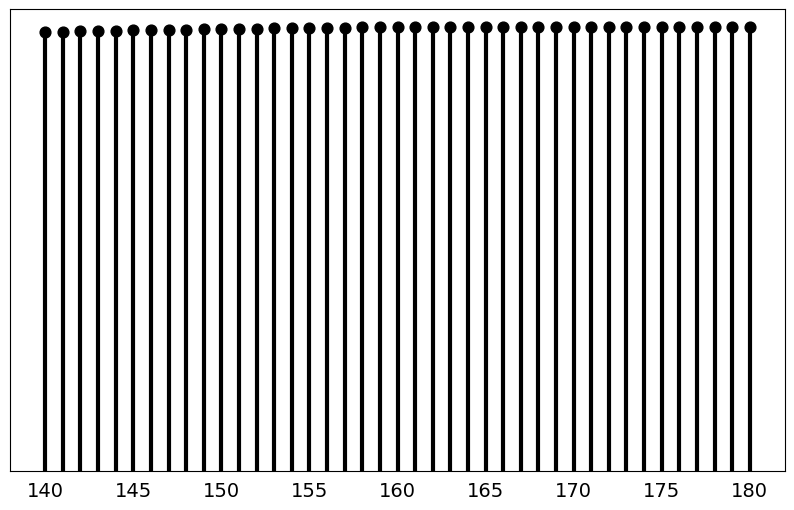

In [31]:
%matplotlib inline
from matplotlib import collections as matcoll
# print(ov_position[int(np.where(cross_corr==np.max(cross_corr))[0])], max(cross_corr))

# ov_position = [3, 4, 5, 6, 7, 8, 9, 10, 11]
# corr = [0.9909849265735179, 0.996767876208091, 0.999480813538509, 0.9965571362709759, 0.9890487794768316, 
#         0.9807278651316307, 0.9727282861279635, 0.9648033317627641, 0.9573152509152888]

# ov_position = range(37 - 10, 37+10+1)

lines = []
for i in range(len(ov_position)):
    pair=[(ov_position[i],0.0), (ov_position[i], cross_corr[i])]
    lines.append(pair)
    
linecoll = matcoll.LineCollection(lines, color='k', linewidths=3)
fig, ax = plt.subplots(figsize=(10,6))
ax.add_collection(linecoll)

# plt.figure()
plt.scatter(ov_position, cross_corr, c='k', s=60)
plt.ylim(min(cross_corr)-0.05, 1)
# plt.xlabel('Overlapping position')
# plt.ylabel('Cross correlation')

plt.tick_params(bottom=False, labelleft=False, left=False, labelsize=14)

168
(190, 190, 3) (190, 190, 3)


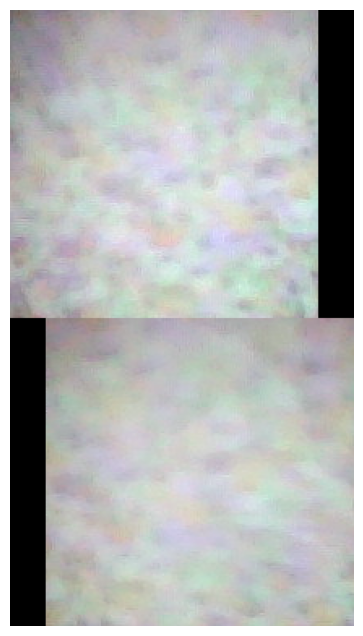

In [32]:
import copy
def stitch(img1, img2, ov_pos, ov1, ov2, blend=False, dim=1):
#     ov_avg = (ov1/2+ov2/2).astype('uint8')
    
    t1 = time.time()
    if blend:
        # linear blending
        ov1_blended = ov1.copy()
        ov2_blended = ov2.copy()
        for i in range(ov_pos):
            blend_coef = -(1/(ov_pos-1))*i + 1
            if dim==1:
                ov1_blended[:,i,:] = ov1[:,i,:]*blend_coef
                ov2_blended[:,i,:] = ov2[:,i,:]*(1.-blend_coef)
            elif dim==0:
                ov1_blended[i, :,:] = ov1[i, :,:]*blend_coef
                ov2_blended[i, :,:] = ov2[i, :,:]*(1.-blend_coef)
        ov_blended = ov1_blended + ov2_blended
        ov = ov_blended
    else:
        ov = ov1
#     print('time: linear blending >>>', time.time() - t1)
    
    if dim == 1:
        stitched_img = np.concatenate((img1[:, :-ov_pos, :], ov, img2[:, ov_pos: :]), axis = 1)
    elif dim == 0:
        stitched_img = np.concatenate((img1[:-ov_pos, :, :], ov, img2[ov_pos:, :, :]), axis = 0)
    
    return stitched_img

def image_alignment(img1, img2, ov_pos, dim=1):
    print(img1.shape, img2.shape)
    height, width1, _ = img1.shape
    _, width2, _ = img2.shape
    if dim == 1:
        blank1 = np.zeros([height, width2-ov_pos, 3]).astype('uint8')
        align_1 = np.concatenate((img1, blank1), axis=1)
        blank2 = np.zeros([height, width1-ov_pos, 3]).astype('uint8')
        align_2 = np.concatenate((blank2, img2), axis=1)
#         print(align_2.shape)
        align_img = np.concatenate((align_1, align_2), axis=0)
    return align_img
        
# 
# ov_pos = 55
plt.figure(figsize=(10, 8))
plt.axis('off')
# print(img1)
print(ov_pos)
# stitched_img = stitch(img1, img2, ov_pos, ov1, ov2, blend=1, dim=dim)
stitched_img = image_alignment(img1, img2, ov_pos, dim=1)
plt.imshow(stitched_img.astype(np.uint8), cmap='gray')

0
0.9957699997255113
0th overlap size in row 0:  144
0.996954990610141
1th overlap size in row 0:  141
0.996049570792202
2th overlap size in row 0:  158
0.9956400698926425
3th overlap size in row 0:  177
Stitched row  width >>>   330
1
0.9956400698926425
0th overlap size in row 1:  177
0.9799250943828092
1th overlap size in row 1:  180
0.9963574295344267
2th overlap size in row 1:  146
0.9962664042847246
3th overlap size in row 1:  144
Stitched row  width >>>   303
1 27
(190, 330, 3) (190, 330, 3)
0.99179383461887
Row overlapping: 179
2
0.9962664042847246
0th overlap size in row 2:  144
0.9962392392757001
1th overlap size in row 2:  168
0.9962072939934864
2th overlap size in row 2:  169
0.9793412125299206
3th overlap size in row 2:  180
Stitched row  width >>>   289
2 41
(201, 330, 3) (190, 330, 3)
0.9890977358139894
Row overlapping: 178
Time elapsed:  0.37580299377441406
[['hor 0', 144], ['hor 1', 141], ['hor 2', 158], ['hor 3', 177], ['ver 0', 0], ['hor 0', 177], ['hor 1', 180], ['ho

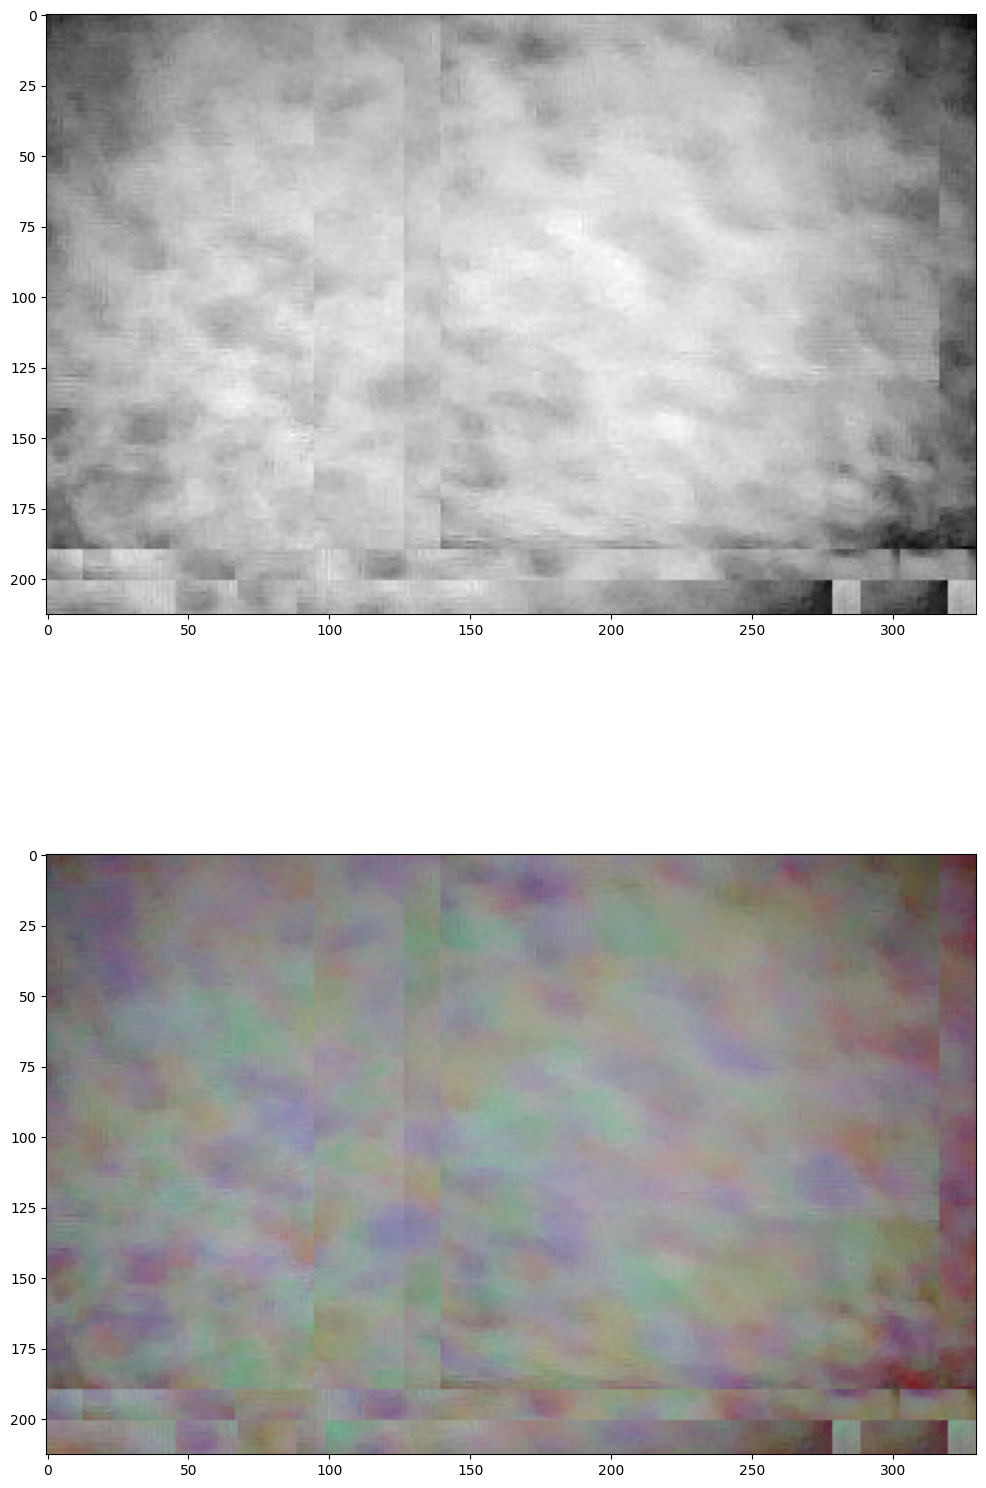

In [33]:
import time

def save_image(image,addr,num):
    address = addr + str(num)+ '.jpg'
    cv2.imwrite(address,image)
    
# print(range(2))
t1 = time.time()
img_stitched_height = None
change_sv = 1
s_mean = 28.0
v_mean = 150.0

stitch_calibration = []

for i in range(nrow):
    img_stitched_width = None
    print(i)
    for j in range(ncol):
#         if i == 0 && j == 0:
        if j == 0:
            if change_sv == False: 
                img_j0 = tile_list[i*4]
            
            else:
                img_j0 = cv2.cvtColor(tile_list[i*4], cv2.COLOR_RGB2HSV)
                img_j0 = img_j0.astype(np.float64)
#                 print("b",img_j0.dtype)
                img_j0[:,:,1] = np.clip(img_j0[:,:,1] * s_mean / np.mean(img_j0[:,:,1]),0.0,255.0)
                img_j0[:,:,2] = np.clip(img_j0[:,:,2] * v_mean / np.mean(img_j0[:,:,2]),0.0,255.0)
                img_j0 = cv2.cvtColor(img_j0.astype(np.uint8), cv2.COLOR_HSV2RGB)
#                 print(img_j0.dtype)

            img_stitched_width = img_j0
#             img_stitched_width = tile_list_histMatched[i*4+j]
        else:
#             print(i*4 + j-1)
            if change_sv == False: 
                img_1 =  tile_list[i*4 + j-1]#tile_list_histMatched[i*4 + j-1]
                img_2 =  tile_list[i*4 + j] #tile_list_histMatched[i*4 + j]
            
            else:
                img_1 = cv2.cvtColor(tile_list[i*3 + j-1], cv2.COLOR_RGB2HSV)
                img_1 = img_1.astype(np.float64)
                img_1[:,:,1] = np.clip(img_1[:,:,1] * s_mean / np.mean(img_1[:,:,1]),0,255)
                img_1[:,:,2] = np.clip(img_1[:,:,2] * v_mean / np.mean(img_1[:,:,2]),0,255)
                img_1 = cv2.cvtColor(img_1.astype(np.uint8), cv2.COLOR_HSV2RGB)

                img_2 = cv2.cvtColor(tile_list[i*3 + j], cv2.COLOR_RGB2HSV)
                img_2 = img_2.astype(np.float64)
                img_2[:,:,1] = np.clip(img_2[:,:,1] * s_mean / np.mean(img_2[:,:,1]),0,255)
                img_2[:,:,2] = np.clip(img_2[:,:,2] * v_mean / np.mean(img_2[:,:,2]),0,255)
                img_2 = cv2.cvtColor(img_2.astype(np.uint8), cv2.COLOR_HSV2RGB)
            
            
            ov_pos, ov1, ov2, c_corr = find_ov(img_1, img_2, nominal_ov=NOMINAL, bound_ov=RANGE, dim=1)
            print('{}th overlap size in row {}: '.format(j-1, i), ov_pos)
            
            stitch_calibration.append(["hor {}".format(j-1),ov_pos])

            
            # stitch images with stacking
            img_stitched_width = stitch(img_stitched_width, img_2, ov_pos, ov1, ov2, blend=False, dim=1)

    print('Stitched row  width >>>  ', img_stitched_width.shape[1])
    if i == 0:
        img_stitched_height = img_stitched_width
        stitch_calibration.append(["ver {}".format(i),0])
        pass
    else:
        width = img_stitched_height.shape[1]
        width_new = img_stitched_width.shape[1]
        wdiff = width - width_new
        print(i, wdiff)
        if wdiff > 0:
            img_stitched_width = np.hstack((img_stitched_width, img_stitched_width[:, -wdiff:]))
        elif wdiff < 0:
            img_stitched_width = img_stitched_width[:, :wdiff]
        print(img_stitched_height.shape,img_stitched_width.shape)
        
        ov_pos_h, ov_h1, ov_h2, c_corr = find_ov(img_stitched_height, img_stitched_width, 
                                         nominal_ov=NOMINAL, bound_ov=RANGE, dim=0)
        stitch_calibration.append(["ver {}".format(i),ov_pos_h])
        
        print('Row overlapping:', ov_pos_h)
        img_stitched_height = stitch(img_stitched_height, img_stitched_width, 
                                     ov_pos_h, ov_h1, ov_h2, blend=False, dim=0)
t = time.time() - t1
print('Time elapsed: ', t)
%matplotlib inline
# img_stitched_height = img_stitched_height[::,80:279]

plt.figure(figsize=(12, 20))
plt.subplot(2,1,1)
plt.imshow(cv2.cvtColor(img_stitched_height,cv2.COLOR_RGB2GRAY), cmap='gray')
plt.subplot(2,1,2)
plt.imshow(img_stitched_height, cmap='gray')
# plt.axis('off')
print(stitch_calibration)

# from tempfile import TemporaryFile
# outfile = TemporaryFile()
np.save('/home/lifan/Documents/GitHub/Tactile-Stereo/test_img/calibration.npy', stitch_calibration)

print(img_stitched_height.shape)

In [34]:
a = np.asarray([1,2,3,4.6,255,257], dtype=np.uint8)
b = np.asarray(["a"])
print(b)
print(a)

['a']
[  1   2   3   4 255   1]


/tmp/ipykernel_459219/2596310301.py:1: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 257 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  a = np.asarray([1,2,3,4.6,255,257], dtype=np.uint8)


In [35]:
import numba as nb # Before this block, the former codes are used to test the range of parameters setup.
import time

import numexpr as ne

img_array = np.array(tile_list)*1.0
print(img_array.shape)
# @nb.njit
def nb_generate_corr_map(img_list, nominal_ov, bound_ov, dim=1):
    range_ov = range(nominal_ov - bound_ov, nominal_ov+bound_ov + 1)
    corr_map = np.zeros((img_list.shape[0]-1, len(range_ov)), dtype=np.double)
#     corr_map = np.zeros((12, 12), dtype=np.double)
    for ind in range(img_list.shape[0]-1):
        img1 = img_list[ind]
        img2 = img_list[ind+1]
        
        cross_corr = np.zeros((bound_ov*2+1), dtype=np.double)
        
        for i, ov in enumerate(range_ov):
            if dim == 1:
                ov_area1 = img1[:, -ov:, :]
                ov_area2 = img2[:,  :ov, :]
            elif dim == 0:
                ov_area1 = img1[-ov:, :, :]
                ov_area2 = img2[:ov,  :, :]
                
            corr = 0.0
    #         print(ov_area1.shape)
            for l in range(3):
                a = ov_area1[:,:,l]
                b = ov_area2[:,:, l]
                corr = corr + np.sum(np.multiply(a, b)) / \
                        np.sqrt(np.sum(np.square(a)) * np.sum(np.square(b)))
            corr = corr/3.0
            cross_corr[i] = corr
        corr_map[ind] = cross_corr
    return corr_map


# import cy_accel_functions.accel_utils as cy_accel


nominal_ov = 200
bound_ov = 30

img_array = img_array * 1.0

print(img_array[4:8].dtype)

t1 = time.time()
print(img_array[0:4].shape)
# nb_generate_corr_map(img_array[0])
row_corr_map = nb_generate_corr_map(img_array[0:4], nominal_ov, bound_ov, dim=1)
# row_corr_map = cy_accel.cy_generate_corr_map(img_array[4:8], nominal_ov, bound_ov, dim=1)
# row_corr_map = np_generate_corr_map(tile_list[0:4], nominal_ov, bound_ov, dim=1)
print('cross correlation computation time: ', time.time() - t1)
print("Correlation map: ")
print(row_corr_map)
range_ov = np.arange(nominal_ov - bound_ov, nominal_ov + bound_ov + 1)
print(range_ov)

from pulp import *
import gurobipy
# solver_list = listSolvers(onlyAvailable=True)
# print(solver_list)
solver = getSolver('GUROBI')

prob = LpProblem("The constrained overlapping selection",LpMaximize) # Throw a problem and its name used in .lp file. There is a param sense of the LP problem objective. Either ~pulp.const.LpMinimize (default) or ~pulp.const.LpMaximize.

n = len(row_corr_map[0])
N = range(n)
choose_vars_ov1 = LpVariable.dicts("ov1_choose_%s", N, 0, 1, cat="Integer") # Setup variables # x1
# print(choose_vars_ov1)
choose_vars_ov2 = LpVariable.dicts("ov2_choose_%s", N, 0, 1, cat="Integer") # x2
choose_vars_ov3 = LpVariable.dicts("ov3_choose_%s", N, 0, 1, cat="Integer") # x3

chosen_value_ov1 = LpVariable("ov1_choosen") # y1
chosen_value_ov2 = LpVariable("ov2_choosen") # y2
chosen_value_ov3 = LpVariable("ov3_choosen") # y3


prob += (chosen_value_ov1+chosen_value_ov2+chosen_value_ov3), "target function" # f = y1+y2+y3

prob += chosen_value_ov1 == lpSum([row_corr_map[0][i] * choose_vars_ov1[i] for i in N]), "chosen_value computation" # y1 = sum(r0 \cdot x1)
prob += lpSum([choose_vars_ov1[i] for i in N]) == 1, "Enforcing only one entry of variable equals to 1"
prob += chosen_value_ov2 == lpSum([row_corr_map[1][i] * choose_vars_ov2[i] for i in N]) # y2 = sum(r1 \cdot x2)
prob += lpSum([choose_vars_ov2[i] for i in N]) == 1
prob += chosen_value_ov3 == lpSum([row_corr_map[2][i] * choose_vars_ov3[i] for i in N]) # y3 = sum(r2 \cdot x3)
prob += lpSum([choose_vars_ov3[i] for i in N]) == 1
prob += lpSum([range_ov[i]*(choose_vars_ov1[i] + choose_vars_ov2[i] + 
                           choose_vars_ov3[i]) for i in N]) == 600, "fixed stitching size constraint" # sum(range*(x1+x2+x3)) = 150, it limits the width of a stitched row, which is helpful for column stitch.
# t1 = time.time()
# start = time()
prob.solve(solver)
# prob.solve(solvers.CPLEX())
# print("problem solving time: ", time.time() - start)
choose_vars_soln = []
choose_vars_soln.append([choose_vars_ov1[i].varValue for i in N]) # varValue is the specific value output format of puLP
choose_vars_soln.append([choose_vars_ov2[i].varValue for i in N])
choose_vars_soln.append([choose_vars_ov3[i].varValue for i in N])




# print(choose_vars_soln)

print('overlapping sizes: ')
print(range_ov[np.nonzero(choose_vars_soln[0])[0]])
print(range_ov[np.nonzero(choose_vars_soln[1])[0]])
print(range_ov[np.nonzero(choose_vars_soln[2])[0]]) # print the ultimate overlap size in row

(15, 190, 190, 3)
float64
(4, 190, 190, 3)
cross correlation computation time:  0.11226296424865723
Correlation map: 
[[0.99802175 0.99801499 0.99801234 0.9980036  0.99800175 0.99799227
  0.99798858 0.99797643 0.99796652 0.99794703 0.99793212 0.99790989
  0.99788709 0.99784958 0.99781236 0.99775522 0.99770049 0.99763049
  0.99756082 0.99747582 0.99739407 0.99739407 0.99739407 0.99739407
  0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
  0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
  0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
  0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
  0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
  0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
  0.99739407]
 [0.99807338 0.99807617 0.9980749  0.99807151 0.99806475 0.99805765
  0.99804791 0.99803838 0.99802234 0.998003   0.99797827 0.99795061
  0.99791859 0.99788268 0.99784051 0.99779496 0.9977

In [36]:
import time
# all images stitching
corr_map = np.empty([nrow, ncol-1, bound_ov*2+1])
t１= time.time()
for i in range(nrow):
#     print(i)
    image_array = img_array[i*ncol: i*ncol + ncol]
    corr_map[i] = nb_generate_corr_map(image_array, nominal_ov, bound_ov, dim=1)
print(time.time()-t1)
print(corr_map)

rows = [1,2,3]
cols = [1,2]
print('n = ', n)
N = range(n)
choose_vars = LpVariable.dicts('choose', (rows, cols, N), 0, 1, cat="Integer")
chosen_values = LpVariable.dicts('chosen_val', (rows, cols), cat="Continuous")
# print(choose_vars)
# print(chosen_values)
prob1 = LpProblem('opt 3 together', LpMaximize)
# print(lpSum([chosen_values[i][j] for i in rows for j in cols]))
prob1 += lpSum([chosen_values[i][j] for i in rows for j in cols]), "cost function"

# assign chosen_values
# print(chosen_values[1][3])
# print(corr_map)
# print(choose_vars[1][3][3])
print(choose_vars[3][2])
# print(range_ov[0])
for i in rows:
    for j in cols:
#         print(chosen_values[i][j] == lpSum([corr_map[i-1, j-1, k]*choose_vars[i][j][k] for k in N]))
#         print('---------------------------')
        prob1 += chosen_values[i][j] == lpSum([corr_map[i-1, j-1, k]*choose_vars[i][j][k] for k in N])
        prob1 += lpSum([choose_vars[i][j][k] for k in N]) == 1
#     print(i)    
    prob1 += lpSum([range_ov[l]*choose_vars[i][k][l] for k in cols for l in N]) == 600
t1 = time.time()
prob1.solve(solver)
print(time.time()-t1)

chosen_sol = np.empty([nrow, ncol-1])
print(chosen_sol)
for i in rows:
    for j in cols:
        print(range_ov[np.nonzero([choose_vars[i][j][l].varValue for l in N])[0]] )
        
        chosen_sol[i-1, j-1] = range_ov[np.nonzero([choose_vars[i][j][l].varValue for l in N])[0] ]
print('overlapping sizes for rows: ')
print(chosen_sol)

# saving overlap sizes
ov_dict ={}
ov_dict['inter_cols'] = chosen_sol.tolist()

0.35893869400024414
[[[0.99802175 0.99801499 0.99801234 0.9980036  0.99800175 0.99799227
   0.99798858 0.99797643 0.99796652 0.99794703 0.99793212 0.99790989
   0.99788709 0.99784958 0.99781236 0.99775522 0.99770049 0.99763049
   0.99756082 0.99747582 0.99739407 0.99739407 0.99739407 0.99739407
   0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
   0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
   0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
   0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
   0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
   0.99739407 0.99739407 0.99739407 0.99739407 0.99739407 0.99739407
   0.99739407]
  [0.99807338 0.99807617 0.9980749  0.99807151 0.99806475 0.99805765
   0.99804791 0.99803838 0.99802234 0.998003   0.99797827 0.99795061
   0.99791859 0.99788268 0.99784051 0.99779496 0.99773975 0.99768019
   0.99761303 0.99754204 0.99746769 0.99746769 0.99746769 0.99746769

ValueError: setting an array element with a sequence.

In [ ]:
# %matplotlib inline
# row_stitched = []
# for i in range(nrow):
#     img_stitched_w = None
#     for j in range(ncol):
# #         if i == 0 && j == 0:
#         if j == 0:
#             img_stitched_w = img_array[i*ncol]
# #             img_stitched_width = tile_list_histMatched[i*4+j]
#             pass
#         else:
#             print(i*4 + j-1, i*4+ j)
#             img1 =  img_array[i*ncol + j-1]#tile_list_histMatched[i*4 + j-1]
#             img2 =  img_array[i*ncol + j] #tile_list_histMatched[i*4 + j]

            
#             ov_pos = int(chosen_sol[i, j-1])
#             print(ov_pos)
#             ov1 = img1[:, -ov_pos:, :]
#             ov2 = img2[:, :ov_pos, :]
#             # stitch images with stacking
#             img_stitched_w = stitch(img_stitched_w, img2, ov_pos, ov1, ov2,True, dim=1)
#     row_stitched.append(img_stitched_w)

# # print(row_stitched[0].astype(np.uint8).shape)
# # # %matplotlib inline
# # plt.figure(figsize=(10,12))
# # plt.subplot(3,1,1)
# # plt.imshow(row_stitched[0].astype(np.uint8), cmap='gray')
# # plt.subplot(3,1,2)
# # plt.imshow(row_stitched[1].astype(np.uint8))
# # plt.subplot(3,1,3)
# # plt.imshow(row_stitched[2].astype(np.uint8))
    

# # print(row_stitched)
# row_stitched = np.array(row_stitched)
# print(row_stitched.shape)
# t1=time.time()
# corr_map_r = nb_generate_corr_map(row_stitched, nominal_ov = 65, bound_ov = 10, dim=0)
# print(time.time() - t1)
# print("corr_map_r",corr_map_r)
# print("max corr", np.where(corr_map_r==max(corr_map_r[0])),np.where(corr_map_r==max(corr_map_r[1])))
# range_ov_r = np.arange(65-10, 65+10 + 1)
# print(range_ov_r)
# NN = range(len(range_ov_r))
# print("NN", NN)


# prob2 = LpProblem('row stitching', LpMaximize)

# rows_between = [1,2]
# choose_var_r= LpVariable.dicts('choose', (rows_between, NN), 0, 1, cat='Integer')
# chosen_value_r = LpVariable.dicts('chosen_val', rows_between, cat='Continuous')

# prob2 += lpSum([chosen_value_r[i] for i in rows_between]), "cost function"

# print(choose_var_r)

# for i in rows_between:
#     prob2 += chosen_value_r[i] == lpSum([corr_map_r[i-1, k]*choose_var_r[i][k] for k in NN])
#     prob2 += lpSum([choose_var_r[i][k] for k in NN]) == 1

    
# # fixed size constraint    
# prob2 += lpSum([range_ov_r[l]*choose_var_r[i][l] for i in rows_between for l in NN]) == 120
    
# t1 = time.time()
# prob2.solve(solver)
# print(time.time()-t1)

# print([choose_var_r[i][l].varValue for l in NN])

# chosen_sol_r = np.empty([nrow-1])
# for i in rows_between:
#     print(np.nonzero([choose_var_r[i][l].varValue for l in NN])[0] )

#     chosen_sol_r[i-1] = range_ov_r[np.nonzero([choose_var_r[i][l].varValue for l in NN])[0] ]
# print(chosen_sol_r)


# # ========== 
# all_stitched = []
# for i in range(nrow):
# #         if i == 0 && j == 0:
#     if i == 0:
#         all_stitched = row_stitched[0]
# #             img_stitched_width = tile_list_histMatched[i*4+j]
#         pass
#     else:
# #             print(i*4 + j-1)
#         img1 =  row_stitched[i-1]#tile_list_histMatched[i*4 + j-1]
#         img2 =  row_stitched[i] #tile_list_histMatched[i*4 + j]
#         print(img1.shape, img2.shape)
# #             time.sleep(0.1)
# #             plt.figure()
# #             plt.subplot(1,2,1)
# #             plt.imshow(img1)
# #             plt.axis('off')
# #             plt.subplot(1,2,2)
# #             plt.imshow(img2)
# #             plt.axis('off')

#         ov_pos = int(chosen_sol_r[i-1])
#         ov1 = img1[-ov_pos:, :, :]
#         ov2 = img2[:ov_pos, :, :]
#         # stitch images with stacking
#         all_stitched = stitch(all_stitched, img2, ov_pos, ov1, ov2, dim=0)

# print(all_stitched.shape)

# %matplotlib inline
# plt.figure(figsize=(10,8))
# plt.imshow(all_stitched.astype(np.uint8))